# **Gamma Ray Spectroscopy**

In [38]:
from sort_csv import *
from process_functions import * 
import matplotlib.pyplot as plt

# Scaling Data Sets

#### Process raw data

In [39]:
bg_noise, bg_noise_uncer = input_bg()
factor, factor_uncer, df_correction  = calculate_correction_factor()
display(df_correction)

/home/dio/Desktop/PHYS128AL/Gamma_Spectroscopy/sort_csv.py:100: RuntimeWarning: overflow encountered in power
  factor = elasped_time_correction * np.e**(activity * t_elasped) * np.e**(-activity * unknown_second)
/home/dio/Desktop/PHYS128AL/Gamma_Spectroscopy/sort_csv.py:100: RuntimeWarning: invalid value encountered in multiply
  factor = elasped_time_correction * np.e**(activity * t_elasped) * np.e**(-activity * unknown_second)


,Unknown,Cs137,Na22,Co57,Co60,Cd109,Ba133,Eu152,Zn65,Mn54
half_life (s),86400.0,948602880.0,81993600.0,23478336.0,166194720.0,39864960.0,334281600.0,426366720.0,21075552.0,26956800.0
produce_date,2019-03-01,2019-03-01,2022-11-03,2022-11-03,2023-01-18,2022-12-16,2023-01-18,2022-09-07,2022-12-01,2019-03-01
t_exp (s),202.07,164.03,108.6,115.54,152.04,143.15,77.2,112.9,83.58,86.05
corr_factor,1.0,1.231054,0.692107,0.055313,0.793877,0.173089,2.025921,1.491726,0.047632,2.291594
uncertainty,1.0,0.001935,0.020919,0.013626,0.008386,0.015796,0.005004,0.003883,0.01199,0.065879


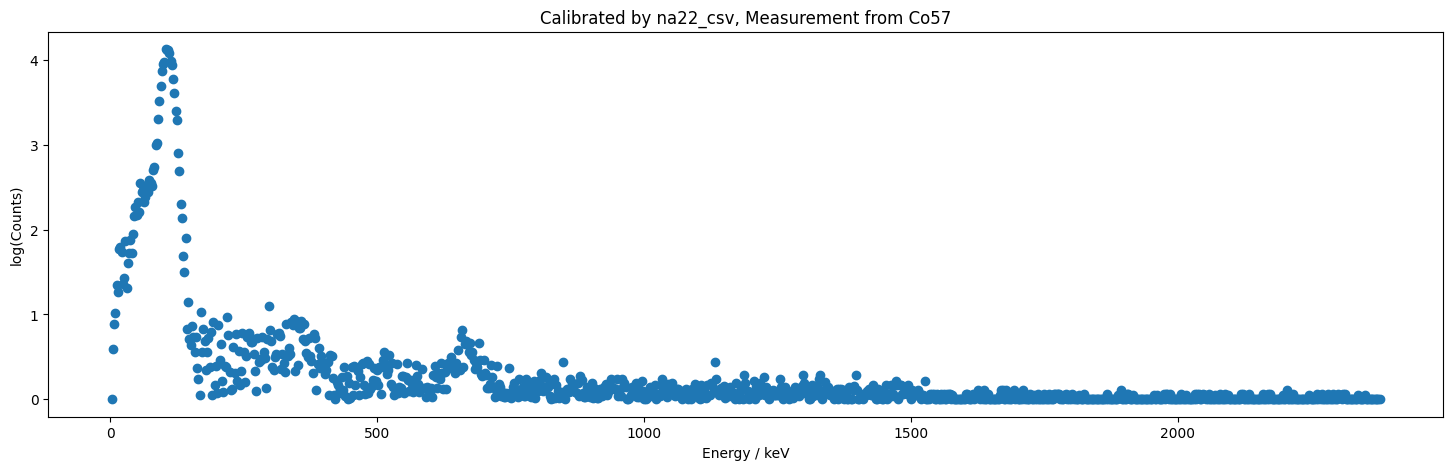

In [54]:
selected_ele = "Co57"
file_name, energy, countss, countss_uncer = read_data(bg_noise, bg_noise_uncer, 
                                                      factor, factor_uncer, 
                                                      plotting=[selected_ele])

### Save figures

In [41]:
def row_column(n):
    row = 0
    column = 0
    for i in range(n):
        column += 1
        if column >= 2:
            row += 1
            column = 0
    return row, column


In [5]:
fig, ax = plt.subplots(5, 2, figsize=(14, 16))
for i in range(len(file_name)):
    r, c = row_column(i)
    ax[r][c].scatter(energy, np.log(countss[i]+1), s=2.5)
    ax[r][c].set_title(f"Measurement from {file_name[i]}", fontweight="bold")
    ax[r][c].set_xlabel("Energy / keV")
    ax[r][c].set_ylabel("log(Counts)")
plt.tight_layout()
plt.savefig(f"figures/raw_counts/all_in_one", format="png")
plt.close()


# Spectral Analysis

#### Find the coordinate of the max counts 

Text(0.5, 0, 'Energy / keV')

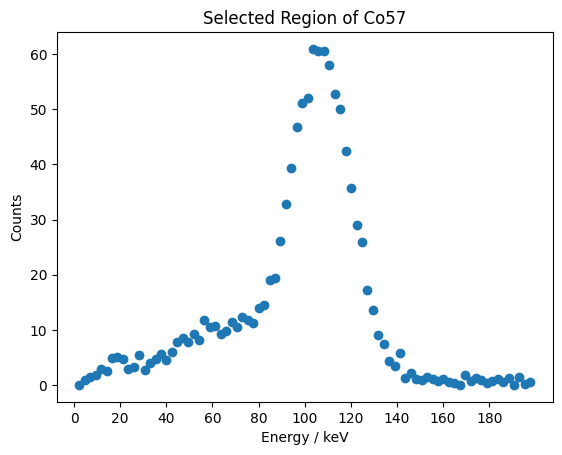

In [60]:
y = countss[file_name.index(selected_ele)]
x = energy
x_min = 0
x_max = 200
x_data, y_data = select_reg(x_min, x_max, x, y)
plt.scatter(x_data, y_data)
plt.title(f"Selected Region of {selected_ele}")
plt.xticks(np.arange(x_min, x_max, int((x_max - x_min)/10)))
plt.ylabel("Counts")
plt.xlabel("Energy / keV")

In [62]:
x_min = 80
x_max = 120
energy_max, counts_max = find_max(x_min, x_max, x_data, y_data)
print(f"The maximum counts of {selected_ele} at range {x_min}keV to {x_max}keV\n"
      f"Located at energy {energy_max}keV, with a total counts of {counts_max}")

The maximum counts of Co57 at range 80keV to 120keV
Located at energy 103.5956790123457keV, with a total counts of 60.94682549868467


#### Gaussian fitting to find spectral properties

N: 96887.49174769025 with uncertainty = 1598.888235558426
Center: 511.94278034764073 with uncertainty = 0.22105607103854383
Peak: 1554.6288356221903


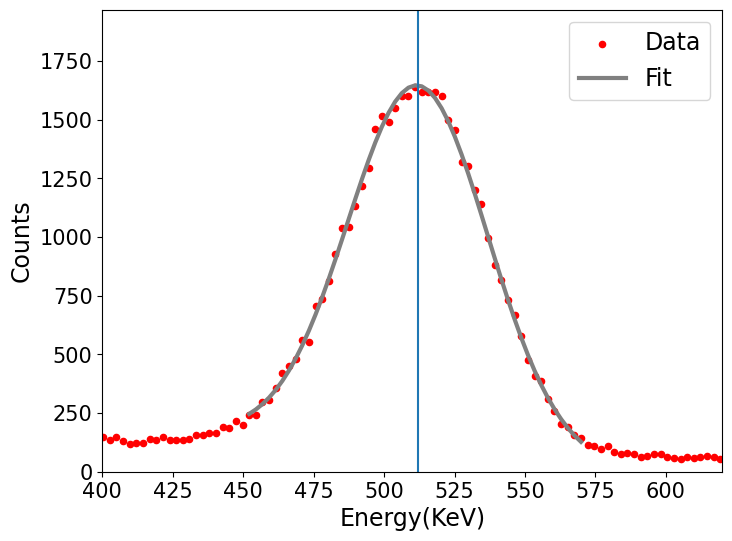

In [44]:
gaussian_fit(x_min, x_max, x_data, y_data)

### Find the closest peaks from the data collected

In [45]:
Unknown = [662.8, 1112]
Unknown_uncer = [0.8,10]

Cs137 = [665.8]
Na22 = [514.9, 1284.5, 1826]
Co57 = [107, 667]
Co60 = [1178, 1335]
Cd107 = [66.3]
Ba133 = [66.3, 348]
Eu152 = [108.8, 243, 344.4]
Zn65 = [508, 1119]
Mn54 = [833]
samples_peak = [Cs137, Na22, Co57, Co60, Cd107, Ba133, Eu152, Zn65, Mn54]
samples_peak_uncer = [[0.7],[2, 10, 10],[3, 10],[1, 3],[2],[2, 4],[0.1, 2, 0.3],[10, 9],[3]]

points = [100 for i in range(len(Unknown))]
names = ["sth" for i in range(len(Unknown))]
peaks = [0 for i in range(len(Unknown))]
peaks_uncer = [0 for i in range(len(Unknown))]
for i in range(len(samples_peak)):
    for j in range(len(Unknown)):
        for k in range(len(samples_peak[i])):
            score = abs(Unknown[j] - samples_peak[i][k])
            if score < points[j]:
                points[j] = score
                names[j] = file_name[i+1]
                peaks[j] = samples_peak[i][k]
                peaks_uncer[j] = samples_peak_uncer[i][k]

print(f"The unknown has peaks in {Unknown[0]} +- {Unknown_uncer[0]}keV and {Unknown[1]} +- {Unknown_uncer[0]}keV")
for i in range(len(Unknown)):
    print(f"At the peak at {Unknown[i]}, the closest isotope is {names[i]} with peak at {peaks[i]} +- {peaks_uncer[i]}."
          f" With difference of {round(points[i], 3)}")

The unknown has peaks in 662.8 +- 0.8keV and 1112 +- 0.8keV
At the peak at 662.8, the closest isotope is Cs137 with peak at 665.8 +- 0.7. With difference of 3.0
At the peak at 1112, the closest isotope is Zn65 with peak at 1119 +- 9. With difference of 7


In [48]:
name_list = ["Unknown", "Cs137", "Zn65"]
Zn65_counts = countss[file_name.index("Zn65")].sum()
Zn65_counts_uncer = countss_uncer[file_name.index("Zn65")].sum()
Cs137_counts = countss[file_name.index("Cs137")].sum()
Cs137_counts_uncer = countss_uncer[file_name.index("Cs137")].sum()
Unknown_counts = countss[file_name.index("Unknown")].sum()
Unknown_counts_uncer = countss_uncer[file_name.index("Unknown")].sum()

pred_add = (1/2) * Cs137_counts + Zn65_counts
pred_add_uncer = np.sqrt(((1/2) * Cs137_counts_uncer)**(2) + Zn65_counts_uncer**(2))

print("Assuming there is 0.5 micro Ci of Cs137 in the sample and 1 micro Ci of Zn65 in the sample\n"
      f"The unknown counts are {Unknown_counts} with uncertainty {Unknown_counts_uncer} and percentage uncertainty {round(100*Unknown_counts_uncer/Unknown_counts, 3)}%\n"
      f"The pred counts are {pred_add} with uncertainty {pred_add_uncer} and percentage uncertainty {round(100*pred_add_uncer/pred_add, 3)}%")


Assuming there is 0.5 micro Ci of Cs137 in the sample and 1 micro Ci of Zn65 in the sample
The unknown counts are 181997.4373469605 with uncertainty 8467.963218355271 and percentage uncertainty 4.653%
The pred counts are 179294.5297606312 with uncertainty 6190.711241507876 and percentage uncertainty 3.453%


## Least Square Prediction on Composition

The predictions are ['Cs137' 'Cd109' 'Zn65']

With proportion of [0.48  0.045 0.996]
uncertainties = [0.0016, 0.2361, 0.0638]
percentage uncertainty of [3.34000e-01 5.21876e+02 6.40800e+00]

The equation that predicts y is stated as 0.48*Cs137 + 0.045*Cd109 + 0.996*Zn65 = Unknown
Each counts contribution is 98.4858 %, 0.0462 %, 1.468 %, 

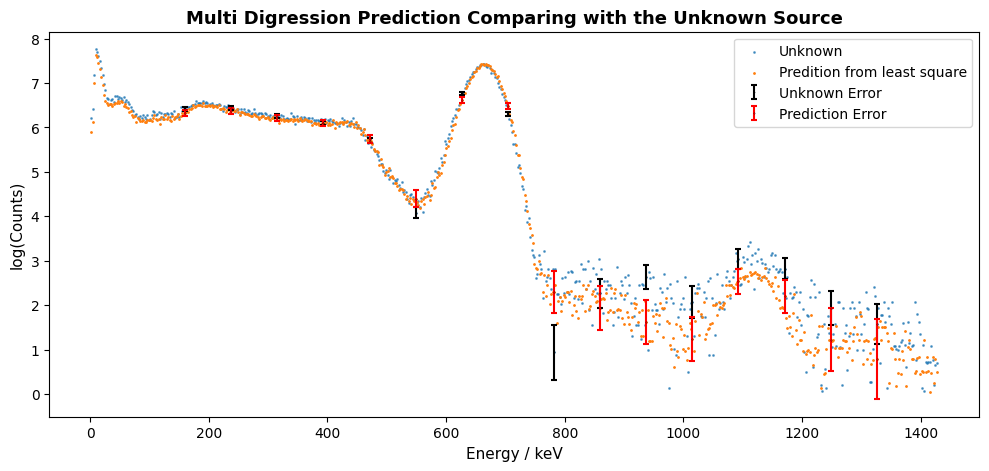

In [50]:
file_name, energy, countss, countss_uncer = read_data(bg_noise, bg_noise_uncer, 
                                                      factor, factor_uncer, 
                                                      plotting=[])
energy, pred, pred_uncer, unknown, unknown_uncer = least_square_weights(file_name, energy, 
                     countss, countss_uncer, 
                     cond1=0.01, cond2=0.1, plotting=True)

### Making Presentable Visuals

In [51]:
from scipy.signal import lfilter

n = 5
b = [1.0 / n] * n
a = 1
unknown = lfilter(b, a, unknown)
pred = lfilter(b, a, pred)

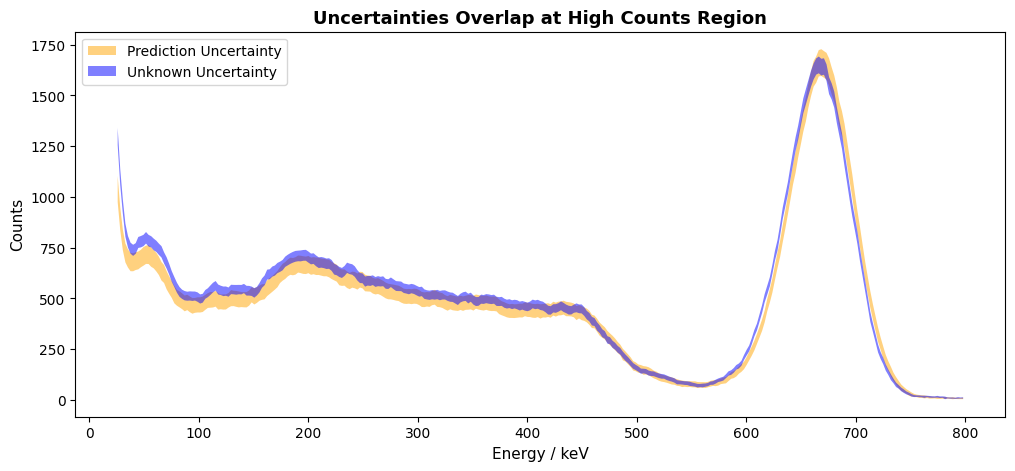

In [52]:
energy_h = energy[np.where(energy<800)]
unknown_h = np.exp(unknown[:(len(energy_h))])
unknown_uncer_h = unknown_uncer[:len(energy_h)] * unknown_h
pred_h = np.exp(pred[:len(energy_h)])
pred_uncer_h = pred_uncer[:len(energy_h)] * pred_h



fig, ax = plt.subplots(figsize=(12, 5))
ax.fill_between(energy_h[10:], (pred_h+pred_uncer_h)[10:], 
                        (pred_h-pred_uncer_h)[10:], facecolor='orange',
                        alpha=0.5, 
                        label="Prediction Uncertainty")
ax.fill_between(energy_h[10:], (unknown_h+unknown_uncer_h)[10:],
                         (unknown_h-unknown_uncer_h)[10:], facecolor='b',
                         alpha=0.5, label="Unknown Uncertainty")
ax.legend(loc=2, fontsize=10)
ax.set_title("Uncertainties Overlap at High Counts Region", fontsize=13, fontweight='bold')
ax.set_ylabel("Counts", fontsize=11)
ax.set_xlabel("Energy / keV", fontsize=11)
plt.savefig("figures/Uncertanty_Overlap_High_Counts", format="png")


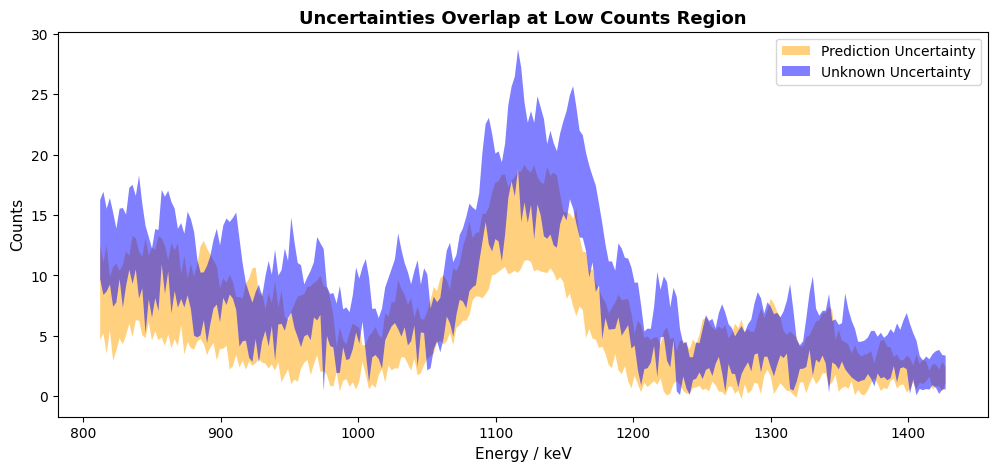

In [53]:
fig, ax = plt.subplots(figsize=(12, 5))

energy_l = energy[np.where(energy>800)]
unknown_l = np.exp(unknown[(len(unknown)-len(energy_l)):])
unknown_uncer_l = unknown_uncer[(len(unknown_uncer)-len(energy_l)):] * unknown_l
pred_l = np.exp(pred[(len(pred)-len(energy_l)):])
pred_uncer_l = pred_uncer[(len(pred_uncer)-len(energy_l)):] * pred_l


ax.fill_between(energy_l[5:], (pred_l+pred_uncer_l)[5:], 
                        (pred_l-pred_uncer_l)[5:], facecolor='orange',
                        alpha=0.5, 
                        label="Prediction Uncertainty")
ax.fill_between(energy_l[5:], (unknown_l+unknown_uncer_l)[5:],
                         (unknown_l-unknown_uncer_l)[5:], facecolor='b',
                         alpha=0.5, label="Unknown Uncertainty")
ax.legend(fontsize=10)
ax.set_title("Uncertainties Overlap at Low Counts Region", fontsize=13, fontweight='bold')
ax.set_ylabel("Counts", fontsize=11)
ax.set_xlabel("Energy / keV", fontsize=11)
plt.savefig("figures/Uncertanty_Overlap_Low_Counts", format="png")